In [37]:
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.manifold import TSNE


In [52]:
class CVariationalAutoEncoder(torch.nn.Module):

    network_architecture = [] # network_architecture : 인공신경망의 구조를 저장
    all_weights = {}
    transfer_fct = 0

    x = [] # x : VAE의 Input
    x_reconstr_mean = [] # x_reconstr_mean : VAE의 Output
    y = [] # y : Input의 label
    z = [] # z : VAE의 latent variable
    z_mean = [] # z_mean : VAE의 latent variable의 mean
    z_log_sigma_sq = [] # z_log_sigma_sq : VAE의 latent variable의 log sigma sq
    
    x_concat = [] # input과 label의 concatenation
    z_concat = [] # latent와 label의 concatenation

    sess = 0
    cost = 0
    optimizer = 0
    

    def __init__(self,network_architecture,transfer_fct=torch.sigmoid):
        super(CVariationalAutoEncoder,self).__init__()
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct # self.transfer_fct : activation function을 저장, 기본값은 sigmoid function으롤 설정
    
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_gener_1, n_hidden_gener_2, n_input, n_z):
        torch.set_default_dtype(torch.double)


        self.all_weights['weights_recog'] = { 'h1' : torch.nn.Parameter(self.xavier_init(n_input+10,n_hidden_recog_1),requires_grad = True), \
                                         'h2' : torch.nn.Parameter(self.xavier_init(n_hidden_recog_1,n_hidden_recog_2),requires_grad = True), \
                                         'out_mean': torch.nn.Parameter(self.xavier_init(n_hidden_recog_2, n_z),requires_grad = True), \
                                         'out_log_sigma': torch.nn.Parameter(self.xavier_init(n_hidden_recog_2, n_z),requires_grad = True)}

        self.all_weights['biases_recog'] = { 'b1' : torch.nn.Parameter(torch.zeros([n_hidden_recog_1]),requires_grad = True), \
                                        'b2' : torch.nn.Parameter(torch.zeros([n_hidden_recog_2]),requires_grad = True), \
                                        'out_mean': torch.nn.Parameter(torch.zeros([n_z]),requires_grad = True), \
                                        'out_log_sigma': torch.nn.Parameter(torch.zeros([n_z]),requires_grad = True)}        
        
        self.all_weights['weights_gener'] = {'h1': torch.nn.Parameter(self.xavier_init(n_z+10, n_hidden_gener_1),requires_grad = True), \
                                        'h2': torch.nn.Parameter(self.xavier_init(n_hidden_gener_1, n_hidden_gener_2),requires_grad = True), \
                                        'out_mean': torch.nn.Parameter(self.xavier_init(n_hidden_gener_2, n_input),requires_grad = True), \
                                        'out_log_sigma': torch.nn.Parameter(self.xavier_init(n_hidden_gener_2, n_input),requires_grad = True)}

        self.all_weights['biases_gener'] = {'b1': torch.nn.Parameter(torch.zeros([n_hidden_gener_1]),requires_grad = True), \
                                       'b2': torch.nn.Parameter(torch.zeros([n_hidden_gener_2]),requires_grad = True), \
                                       'out_mean': torch.nn.Parameter(torch.zeros([n_input]),requires_grad = True), \
                                       'out_log_sigma': torch.nn.Parameter(torch.zeros([n_input]),requires_grad = True)}
        return self.all_weights
    

    def forward (self, x, y):
        self.x = x
        self.y = y
        self.x_concat = torch.cat((x, y), 1) # input + label
        
        #recognition network
        weights, biases = self.all_weights["weights_recog"], self.all_weights["biases_recog"] 
        self.z_mean, self.z_log_sigma_sq = self._recognition_network(weights,biases,self.x_concat)
        
        #reparameterization
        self.z, self.z_concat = self._reparameterization(self.z_mean, self.z_log_sigma_sq)

        #generator network
        weights, biases = self.all_weights["weights_gener"], self.all_weights["biases_gener"]       
        self.x_reconstr_mean = self._generator_network(weights,biases, self.z_concat)
        
        reconstr_loss = -torch.sum(x*torch.log(1e-10+self.x_reconstr_mean)+(1-x)*torch.log(1e-10+1-self.x_reconstr_mean),1)
        latent_loss = -0.5*torch.sum(1+self.z_log_sigma_sq-torch.square(self.z_mean)-torch.exp(self.z_log_sigma_sq),1)

        self.cost = torch.mean(reconstr_loss+latent_loss)
        return self.cost

    def _recognition_network(self,weights,biases,x_concat=None): 

        # VAE의 recognition network의 역할을 수행하는 method
        # Input : (recognition network의) weights, biases
        # Output: (z_mean, z_log_sigma_sq)
        layer_1 = self.transfer_fct(torch.add(torch.matmul(x_concat, weights['h1']), biases['b1'])) # L1 = g(b1 + W1*X)
        layer_2 = self.transfer_fct(torch.add(torch.matmul(layer_1, weights['h2']), biases['b2'])) # L2 = g(b2 + W2*L1)
        
        z_mean = torch.add(torch.matmul(layer_2,weights['out_mean']),biases['out_mean']) # z_mean = b_{out_mean} + W_{out mean}*L2
        z_log_sigma_sq = torch.add(torch.matmul(layer_2,weights['out_log_sigma']),biases['out_log_sigma'])
        # z_log_sigma_sq = b_{log_sigma_sq} + W_{log_sigma_sq}*L2
        return (z_mean,z_log_sigma_sq)

    def _generator_network(self,weights,biases,z_concat=None):

        # VAE의 generator network의 역할을 수행하는 method
        # Input : (generator network의) weights, biases
        # Output : x_reconstr_mean
        layer_1 = self.transfer_fct(torch.add(torch.matmul(z_concat, weights['h1']), biases['b1'])) # L1 = g(b1 + W1*Z)
        layer_2 = self.transfer_fct(torch.add(torch.matmul(layer_1, weights['h2']), biases['b2'])) # L2 = g(b2 + W2*L1)
        x_reconstr_mean = torch.sigmoid(torch.add(torch.matmul(layer_2, weights['out_mean']), biases['out_mean']))
        # x_reconstr_mean = b_{out_mean}+W_{out_mean}*L2
        return x_reconstr_mean

    def _reparameterization(self, z_mean, z_log_sigma_sq):
        # Z mean과 Z sigma를 이용해 Z를 reparameterize하는 method
        # Input : z_mean, z_log_sigma_sq
        # Output : z, z_concat
        
        n_z = self.network_architecture["n_z"]
        n_batch = len(z_log_sigma_sq)
        eps = torch.normal(mean=0, std=1, size=(n_batch, n_z), dtype=torch.double)

        z = torch.add(z_mean,torch.mul(torch.sqrt(torch.exp(z_log_sigma_sq)),eps))
        z_concat = torch.cat((z, self.y), 1) # latent + label

        return z, z_concat

    def get_weights(self):
        # Training될 weight를 모두 반환하는 method
        
        weights = []
        weights.append(self.all_weights["weights_recog"]['h1'])
        weights.append(self.all_weights["biases_recog"]['b1'])
        weights.append(self.all_weights["weights_recog"]['h2'])
        weights.append(self.all_weights["biases_recog"]['b2'])
        weights.append(self.all_weights["weights_recog"]['out_mean'])
        weights.append(self.all_weights["biases_recog"]['out_mean'])        
        weights.append(self.all_weights["weights_recog"]['out_log_sigma'])
        weights.append(self.all_weights["biases_recog"]['out_log_sigma'])
        weights.append(self.all_weights["weights_gener"]['h1'])
        weights.append(self.all_weights["biases_gener"]['b1'])
        weights.append(self.all_weights["weights_gener"]['h2'])
        weights.append(self.all_weights["biases_gener"]['b2'])
        weights.append(self.all_weights["weights_gener"]['out_mean'])
        weights.append(self.all_weights["biases_gener"]['out_mean'])     
        
        return weights
    
    def _create_loss_optimizer(self,learning_rate):
        # VAE의 total cost를 계산하고, 이를 minimize하는 optimizer 설정하는 메소드
        # Input : learning_rate
        # Output : None
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(self.get_weights(), lr=learning_rate)

    def transform(self,input_x, input_y):
        # CVAE의 encoder network를 통하여 latent variable z_mean과 y의 concatenation을 return하는 메소드
        # Input : x, y
        # Output : z_concat        
        x_concat = torch.cat((input_x,input_y),1)
        z_mean, z_log_sigma_sq = self._recognition_network(self.all_weights['weights_recog'],self.all_weights["biases_recog"],x_concat)
        z_concat =  torch.cat((z_mean, input_y), 1)
        
        return z_concat
    
    def generate(self,z_concat):
        # CVAE의 decoder network를 통하여 reconstruct된 mean을 return하는 메소드
        # Input : z_concat
        # Output : reconstr_mean   
        
        reconstr_mean = self._generator_network(self.all_weights["weights_gener"],self.all_weights["biases_gener"],z_concat)
        return reconstr_mean
    
    def reconstruct(self,x,y):
        # CVAE를 통하여 X를 reconstruct한 후, 이 mean을 return하는 메소드
        # Input : x,y
        # Output : (CVAE를 통한) x_reconstr_mean        
        return self.generate(self.transform(x,y))

    def xavier_init(self,fan_in, fan_out, constant=1): 
        # Xavier initialization method
        # Input : fan_in(들어오는 layer의 크기), fan_out(나가는 layer의 크기)
        # Output : 각 원소가 random uniform value인 (fan_in, fan_out) 형태의 tensor 
        low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
        high = constant * np.sqrt(6.0 / (fan_in + fan_out))
        return torch.DoubleTensor(fan_in, fan_out).uniform_(low, high)

    def train(self,train_loader,batch_size=100,training_epochs=500,learning_rate=0.0005):
        # CVAE를 생성하고, trainX/Y를 training하는 메소드
        # Input : trainX, trainY, batch_size, training_epochs, learning_rate
        # Output : None
        total_costs = np.zeros(training_epochs)
        
        self.all_weights = self._initialize_weights(**self.network_architecture) #weight 초기화
        self._create_loss_optimizer(learning_rate) # VAE의 loss function과 optimizer 생성
        
        
        startTime = time.time()
        for epoch in range(training_epochs): # training_epochs만큼 반복 실행
            avg_cost = 0. # training set의 average cost 
            total_batch = len(train_loader) # total batch : 전체 batch의 갯수

            for x_batch, y_batch in train_loader: 
                x_batch = torch.reshape(x_batch,(100,784)).double()
                y_batch = y_batch.view(-1,1)
                one_hot = torch.zeros(100,10)
                y_one_hot = one_hot.scatter_(1,y_batch,1)
                
                cost = self.forward(x_batch, y_one_hot)
                self.optimizer.zero_grad()
                cost.backward()
                self.optimizer.step()
                
                avg_cost += cost / total_batch
            
            total_costs[epoch] = avg_cost
            
            print("Epoch : ",'%04d'%(epoch+1)," Cost = ","{:.9f}".format(avg_cost))
            print("Elapsed Time : " + str((time.time() - startTime))) # 각 epcoh의 실행 소요 시간
       
        # epcch에 따른 cost 그래프 출력 과정
        plt.plot(total_costs)
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.show()
        return
    
    def plotReconstruct(self,testData,testAmount,strFileName):
    # testData를 VAE를 통해 reconstruct한 후, Input test image와 reconstructedf output image를 plot하는 메소드  
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])
            
        # test data에 붙일 label 생성
        label = []
        for i in range(10):
            label.append([])
            for j in range(10):
                label[i].append(0)
            for k in range(10):
                if k == i:
                    label[i][k] = 1
            label[i] = np.array(label[i]) # 0~9 one hot vector : label[i] means i

        # x_reconstruct : testData와 testLabel을 이용하여 reconstruct한 데이터
        x_reconstruct = []
        for n in range(10):
            x_reconstruct.append([])
        for i in range(10):
            Labellist = []
            for data in range(testAmount):
                Labellist.append(label[i])
            Labellist = torch.tensor(Labellist)
            x_reconstruct[i] = self.reconstruct(testData, Labellist) # reconstruct(testData, label[i])        

        plt.figure(figsize=(35, 50))
        samplenum = 20
        for d_num in range(samplenum): # testData의 처음 samplenum개를 plot
            
            # Original Input image plot
            plt.subplot(samplenum, 11, 11 * d_num + 1) #원래 그림
            plt.imshow(testData[d_num].reshape(28, 28), vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환
            plt.title("Test Input")
            plt.colorbar()
            
            # Reconstructed Output image plot
            for l_num in range(10):
                plt.subplot(samplenum, 11, 11 * d_num + l_num + 2) # l num을 label로 reconstruction한 그림
                temp = torch.reshape(x_reconstruct[l_num][d_num], [28, 28])
                temp = temp.cpu().detach().numpy()                
                plt.imshow(temp, vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환
                plt.title("Reconstruction"+str(l_num))
                plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()
        
        
    def plotScatter2D(self,testDataFeature,testDataClass,strFileName):
        # test data와 label을 2-D latent Space위에 Scatter plot으로 표현하는 메소드
        
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])
        z_mu = self.transform(testDataFeature, testDataClass)
        z_mu = z_mu.cpu().detach().numpy()


        plt.figure(figsize=(8, 6))
        plt.scatter(z_mu[:,0],z_mu[:,1],c=np.argmax(testDataClass,1))
        plt.colorbar()
        plt.grid()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()    

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=100)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...


/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


Epoch :  0001  Cost =  -4094.519233758
Elapsed Time : 52.20605802536011
Epoch :  0002  Cost =  -4288.787205711
Elapsed Time : 101.51036429405212
Epoch :  0003  Cost =  -4446.875866034
Elapsed Time : 152.2858603000641
Epoch :  0004  Cost =  -4935.551314856
Elapsed Time : 201.9927191734314
Epoch :  0005  Cost =  -5428.125193647
Elapsed Time : 251.09307503700256
Epoch :  0006  Cost =  -6023.595588118
Elapsed Time : 300.5179510116577
Epoch :  0007  Cost =  -6609.916974102
Elapsed Time : 350.5562570095062
Epoch :  0008  Cost =  -6964.823472863
Elapsed Time : 400.6846179962158
Epoch :  0009  Cost =  -7186.953962708
Elapsed Time : 452.8268082141876
Epoch :  0010  Cost =  -7349.146751475
Elapsed Time : 505.77534222602844
Epoch :  0011  Cost =  -7498.855040399
Elapsed Time : 556.039263010025
Epoch :  0012  Cost =  -7616.753109130
Elapsed Time : 605.28156208992
Epoch :  0013  Cost =  -7703.979120035
Elapsed Time : 655.2597932815552
Epoch :  0014  Cost =  -7777.057520430
Elapsed Time : 707.661335

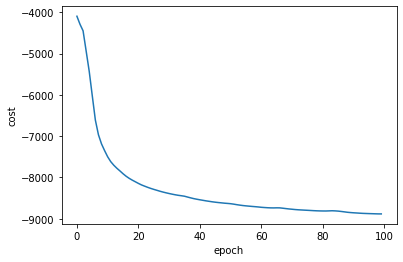

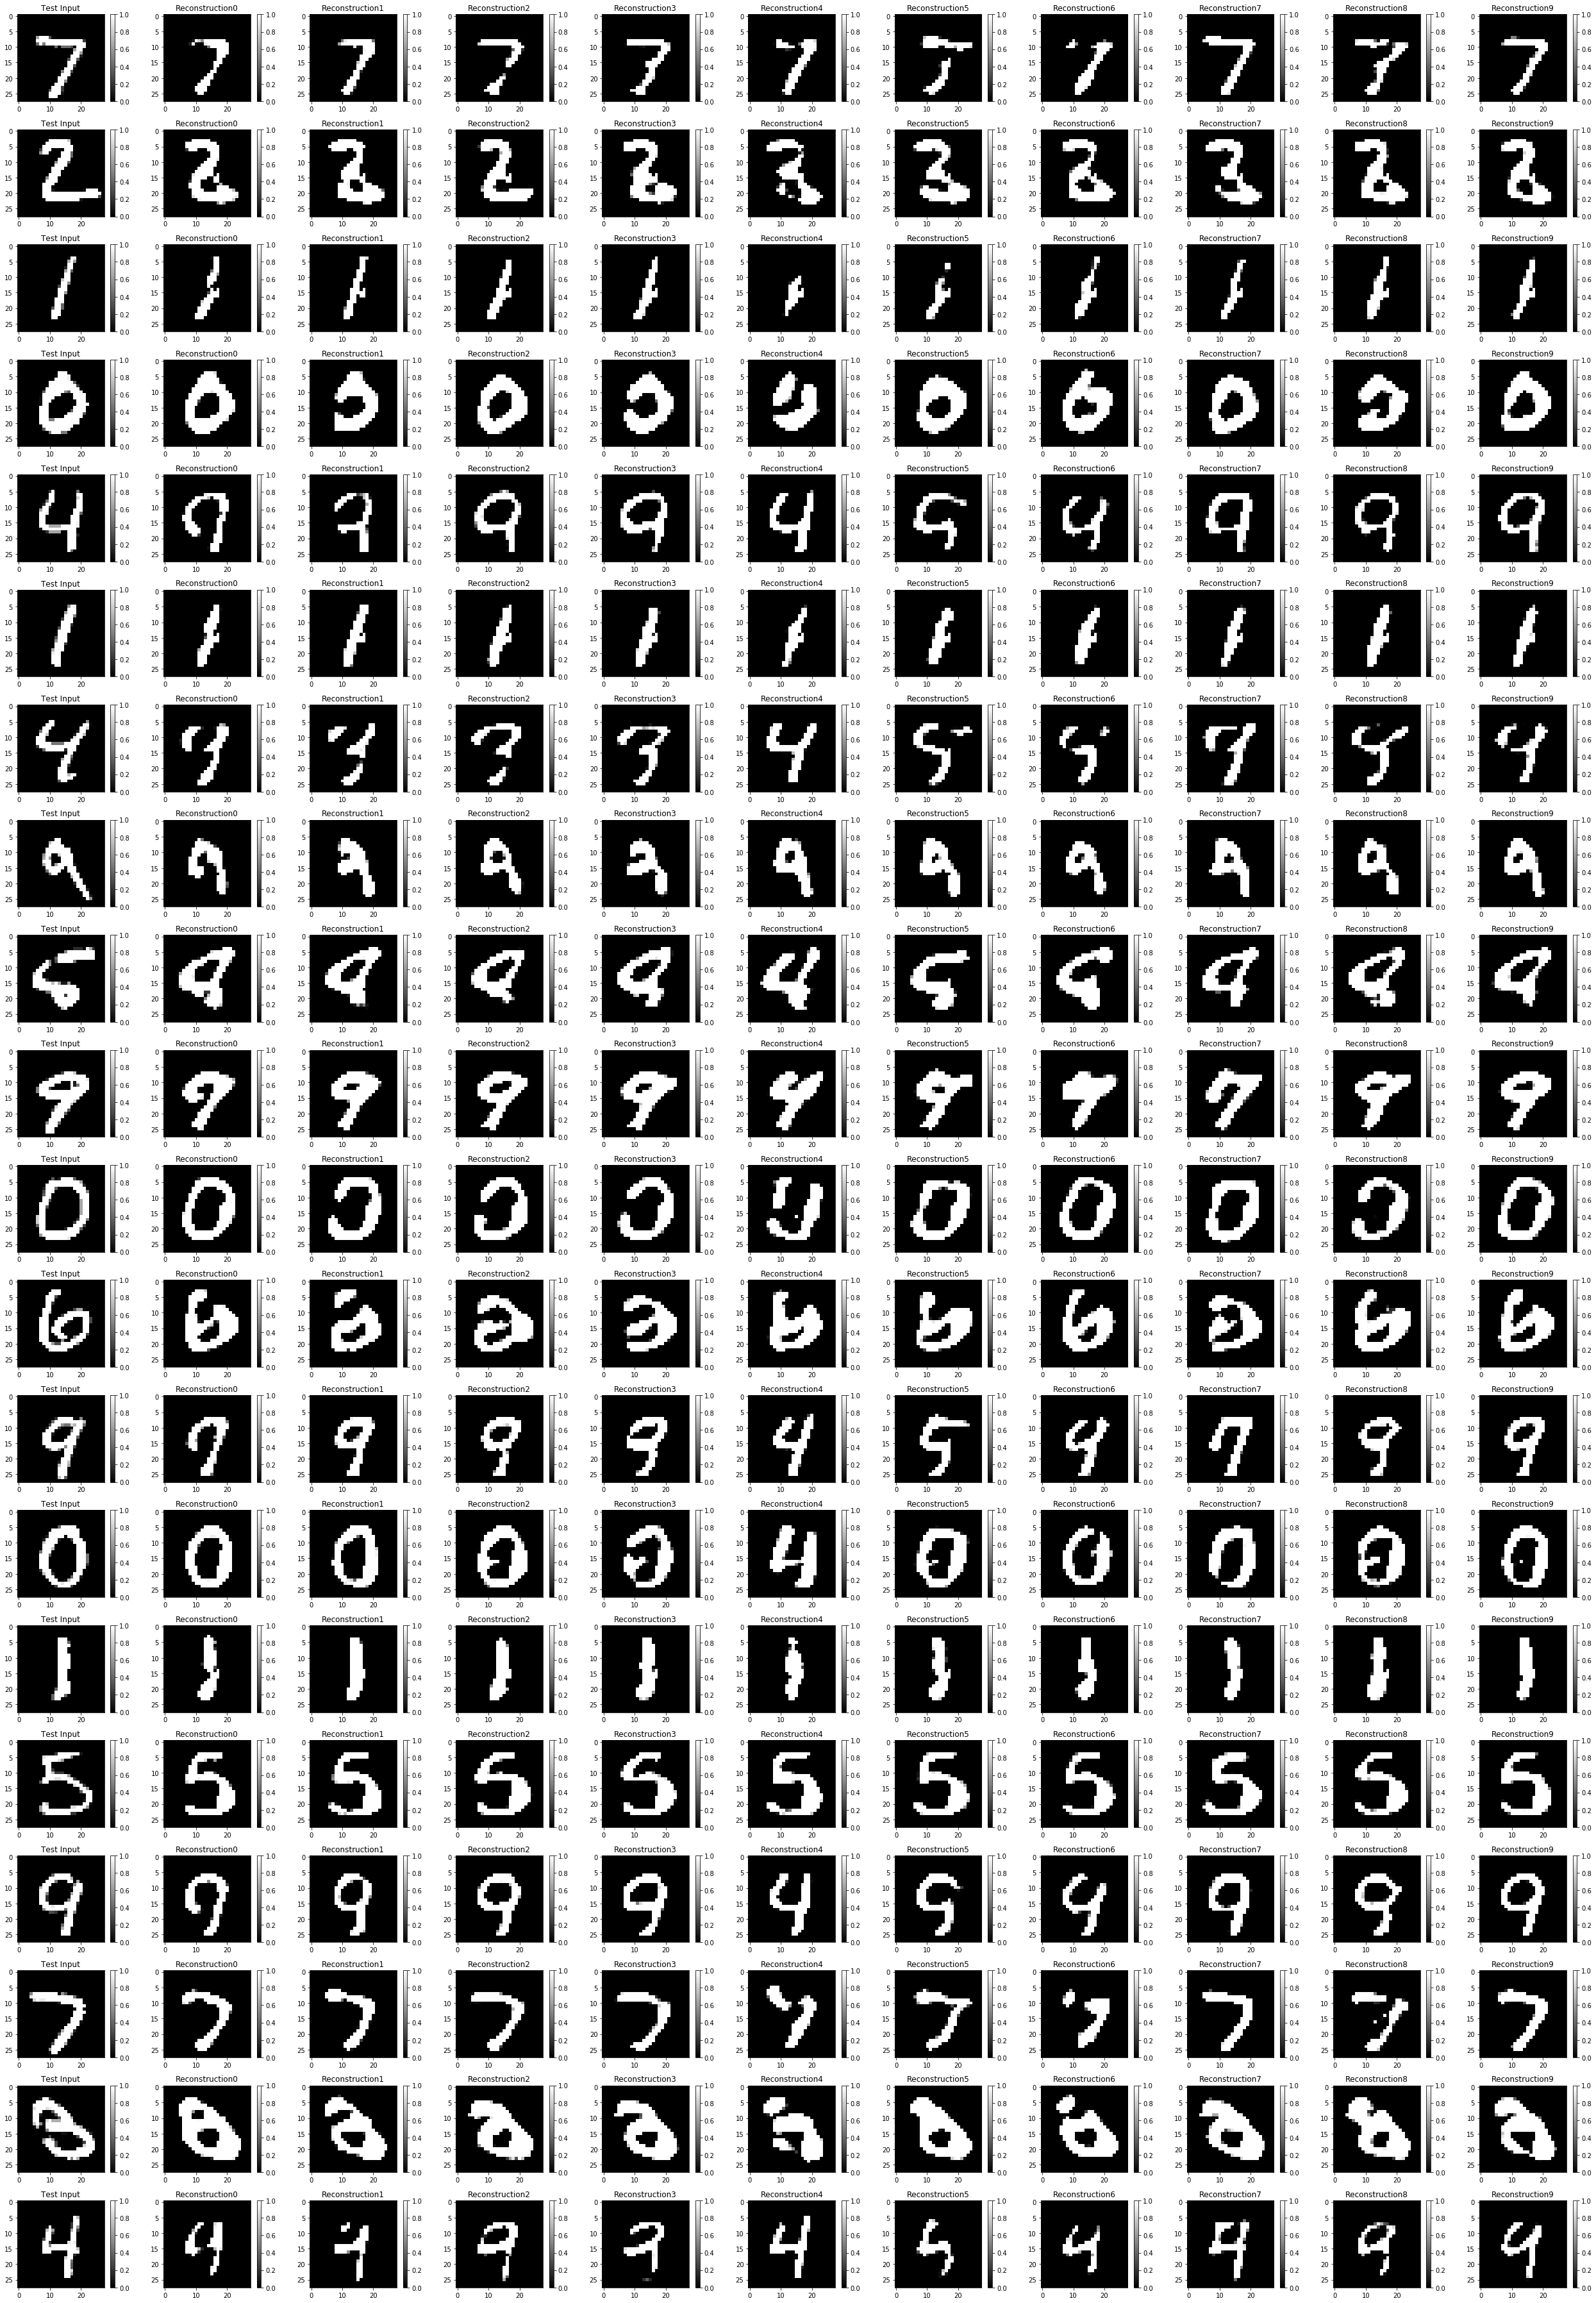

In [53]:
# z dimension이 10인 CVAE의 구조를 저장
# 784 500 500 10 500 500 784
network_architecture = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=10)

cvae = CVariationalAutoEncoder(network_architecture) # z dimension이 10인 VAE instance 생성
cvae.train(train_loader,batch_size=100,training_epochs=100,learning_rate=0.001) # VAE training
cvae.plotReconstruct(x_test,10000,'./log/VAE-Reconstruct.png') # testX를 이용하여 reconstruct한 후 이를 plot

Epoch :  0001  Cost =  -4095.496199788
Elapsed Time : 49.96501302719116
Epoch :  0002  Cost =  -4288.870173277
Elapsed Time : 99.38642621040344
Epoch :  0003  Cost =  -4289.211807235
Elapsed Time : 150.8313593864441
Epoch :  0004  Cost =  -4462.790438043
Elapsed Time : 201.1461193561554
Epoch :  0005  Cost =  -4939.241427143
Elapsed Time : 250.1149981021881
Epoch :  0006  Cost =  -5375.027154936
Elapsed Time : 298.80691933631897
Epoch :  0007  Cost =  -5973.980794107
Elapsed Time : 348.82677125930786
Epoch :  0008  Cost =  -6362.911325369
Elapsed Time : 397.12894320487976
Epoch :  0009  Cost =  -6560.572865288
Elapsed Time : 448.9247670173645
Epoch :  0010  Cost =  -6681.495875812
Elapsed Time : 497.7767381668091
Epoch :  0011  Cost =  -6769.650150167
Elapsed Time : 546.852117061615
Epoch :  0012  Cost =  -6838.569610598
Elapsed Time : 595.7699882984161
Epoch :  0013  Cost =  -6894.270175082
Elapsed Time : 645.613555431366
Epoch :  0014  Cost =  -6937.207656802
Elapsed Time : 695.29605

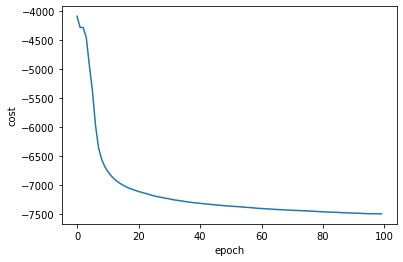

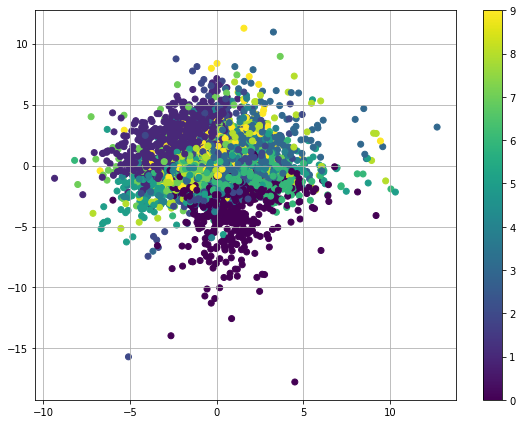

In [54]:
y_test = 0
for testX, testY in test_loader:
    x_test = torch.reshape(testX,(10000,784)).double()
    y_test = testY
    
# z dimentsion이 2인 CVAE의 구조를 저장
# 784 500 500 2 500 500 784
network_architecture2D = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=2)


cvae2D = CVariationalAutoEncoder(network_architecture2D) # latent variable이 2차원이므로 평면에 점을 찍어 나타낼 수 있다.
cvae2D.train(train_loader,batch_size=1000,training_epochs=100,learning_rate=0.001)

y_one_hot = 0
for x_batch, y_batch in test_loader: 
    y_batch = y_batch.view(-1,1)
    one_hot = torch.zeros(10000,10)
    y_one_hot = one_hot.scatter_(1,y_batch,1)
    
cvae2D.plotScatter2D(x_test,y_one_hot,'./log/VAE-2D-Scatter.png')

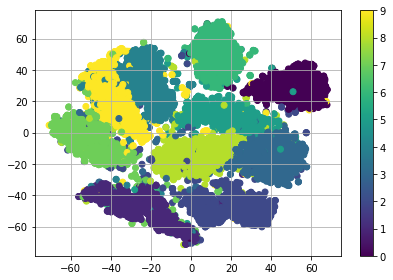

In [55]:
model = TSNE(learning_rate=100) #t-SNE
transformed = model.fit_transform(x_test,y_one_hot) # t-SNE의 결과를 반환해준다

df = pd.DataFrame()
df['x'], df['y'] = transformed[:,0], transformed[:,1]

cs = [] # one-hot vector로 들어가있는 label을 숫자로 표현해서 색으로 사용할 것이다.
for i in range(len(y_one_hot)):
    for j in range(10):
        if y_one_hot[i][j] == 1:
            cs.append([j])
df['c'] = np.array(cs)

plt.scatter(df['x'], df['y'], c=df['c'])
plt.colorbar()
plt.grid()

plt.tight_layout()
plt.show()